# 물체 검출 결과 평가 방법 이해하기

1. 주어진 recall값에 대한 precision과 confidence threshold 값을 계산합니다.<br/>
    + 계산한 threshold 값을 이용하여 검출 결과를 출력합니다. (practice 1.ipynb 활용) <br/>    
2. 주어진 confidence threshold 값에서의 precision과 recall값을 구해봅니다.    

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection, BaseTransform
import torch.utils.data as data
from utils import Timer
from ssd import build_ssd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2

# %matplotlib inline
from matplotlib import pyplot as plt

import xml.etree.ElementTree as ET

labelmap = (  # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

annopath = os.path.join(VOC_ROOT, 'VOC2007', 'Annotations', '%s.xml')
imgpath = os.path.join(VOC_ROOT, 'VOC2007', 'JPEGImages', '%s.jpg')
imgsetpath = os.path.join(VOC_ROOT, 'VOC2007', 'ImageSets', 'Main', '{:s}.txt')
YEAR = '2007'
# devkit_path = VOC_ROOT + 'VOC' + YEAR
dataset_mean = (104, 117, 123)

if torch.cuda.is_available():    
    torch.set_default_tensor_type('torch.cuda.FloatTensor')    
else:
    torch.set_default_tensor_type('torch.FloatTensor')    

## SSD 모델 및 PASCAL VOC2007 데이터 셋 로드

In [2]:
### load net
num_classes = len(labelmap) + 1      # +1 for background
net = build_ssd('vgg16', 300, 21)    # initialize SSD
# checkpoint = 'weights/ssd300_before_optimize.v2.pth'
checkpoint = 'weights/ssd300_epoch_003.v2.pth'
# checkpoint = 'weights/ssd300_mAP_77.43_v2.pth'
net.load_weights(checkpoint)

net.eval()
print('Finished loading model!')

### load data
set_type = 'test'
dataset = VOCDetection(VOC_ROOT, [('2007', set_type)],
                       BaseTransform(300, dataset_mean),
                       VOCAnnotationTransform())

if torch.cuda.is_available():
    net = net.cuda()
    cudnn.benchmark = True

Loading weights into state dict...
Finished!
Finished loading model!


## 물체 검출 수행
Practice 1과 같이 물체 검출을 모든 테스트 셋에 속하는 영상에 대하여 수행합니다.

In [ ]:
save_folder = '_'.join(['ssd300', os.path.basename(checkpoint)])

from layers import Detect

num_images = len(dataset)
parser = Detect(num_classes, 0, 200, 0.01, 0.45)
softmax = nn.Softmax(dim=-1)

# all detections are collected into:
#    all_boxes[cls] = N x 6 array of detections in
#    (x1, y1, x2, y2, score, ids)
all_boxes =[np.zeros((0,6)) for _ in range(len(labelmap)+1)]

# timers
_t = {'forward': Timer(), 'misc': Timer()}    
        
output_dir = os.path.join(save_folder, set_type)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
det_file = os.path.join(output_dir, 'detections.pkl')

if not os.path.exists(det_file):
    for i in range(num_images):    
        im, gt, h, w, ids = dataset.pull_item_with_index(i)

        x = im.unsqueeze(0)
        if torch.cuda.is_available():
            x = x.cuda()

        _t['forward'].tic()
        with torch.no_grad():    
            loc_pred, cls_pred, priors = net(x)            
        forward_time = _t['forward'].toc(average=True)    

        _t['misc'].tic()
        detections = parser(loc_pred, softmax(cls_pred), priors.type(type(x)))                
                
        # skip j = 0, because it's the background class
        for j in range(1, detections.size(1)):
            dets = detections[0, j, :]    # detections for j-th target class                        
            mask = dets[:, 0].gt(0.).expand(5, dets.size(0)).t()
            dets = torch.masked_select(dets, mask).view(-1, 5)
            if dets.shape[0] == 0:
                continue
            boxes = dets[:, 1:]
            boxes[:, 0] *= w    # because, box coordinates were normalized to [0,1]
            boxes[:, 2] *= w
            boxes[:, 1] *= h
            boxes[:, 3] *= h
            scores = dets[:, 0].cpu().numpy()

            ids_dets = ids*np.ones( (len(scores),1) )    # store image index for evaluation
            cls_dets = np.hstack(    # cls_dets: M x 6 matrix [[x,y,w,h,score,img_idx]]
                (boxes.cpu().numpy(),\
                 scores[:, np.newaxis], \
                 ids_dets
                )).astype(np.float32, copy=False)                
            all_boxes[j] = np.vstack( (all_boxes[j], cls_dets) )
            
        misc_time = _t['misc'].toc(average=True)
        
        if i % 100 == 0:
            print('[im_detect: {:d}/{:d}] forward: {:.3f}s, misc: {:.3f}s'.format(i+1, num_images, forward_time, misc_time))
            
    with open(det_file, 'wb') as f:
        pickle.dump(all_boxes, f, pickle.HIGHEST_PROTOCOL)    
        
    print('Saved to {:}.'.format(det_file))
else:
    with open(det_file, 'rb') as f:
        all_boxes = pickle.load(f)    
    print('Load from {:}.'.format(det_file))    

[im_detect: 1/4952] forward: 2.156s, misc: 0.101s
[im_detect: 101/4952] forward: 0.025s, misc: 0.129s
[im_detect: 201/4952] forward: 0.014s, misc: 0.136s
[im_detect: 301/4952] forward: 0.011s, misc: 0.134s
[im_detect: 401/4952] forward: 0.009s, misc: 0.131s
[im_detect: 501/4952] forward: 0.008s, misc: 0.131s
[im_detect: 601/4952] forward: 0.007s, misc: 0.131s
[im_detect: 701/4952] forward: 0.007s, misc: 0.132s
[im_detect: 801/4952] forward: 0.006s, misc: 0.133s
[im_detect: 901/4952] forward: 0.006s, misc: 0.134s
[im_detect: 1001/4952] forward: 0.006s, misc: 0.134s
[im_detect: 1101/4952] forward: 0.006s, misc: 0.134s
[im_detect: 1201/4952] forward: 0.006s, misc: 0.137s
[im_detect: 1301/4952] forward: 0.006s, misc: 0.139s
[im_detect: 1401/4952] forward: 0.005s, misc: 0.141s
[im_detect: 1501/4952] forward: 0.005s, misc: 0.142s
[im_detect: 1601/4952] forward: 0.005s, misc: 0.142s
[im_detect: 1701/4952] forward: 0.005s, misc: 0.143s
[im_detect: 1801/4952] forward: 0.005s, misc: 0.145s
[im_d

## 정답 데이터(Ground truth) 획득
PASCAL VOC2007 데이터셋에서 제공하는 bounding box 정보들을 로드하기 위한 함수입니다.

In [4]:
def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text) - 1,
                              int(bbox.find('ymin').text) - 1,
                              int(bbox.find('xmax').text) - 1,
                              int(bbox.find('ymax').text) - 1]
        objects.append(obj_struct)

    return objects

## 검출 성능 평가 함수
주어진 클래스(classname)에 대해서 성능을 평가하는 함수입니다.
parse_rec 함수를 이용하여 정답 데이터를 로드하고, 
검출된 결과들이 있다면(det_boxes) 다음과 같이 성능을 평가합니다.

    0. 검출 결과를 confidence score순으로 정렬합니다.
    1. 높은 confidence를 가지는 검출 결과부터 시작하여, 해당 검출 결과가 발생한 영상의 정답(GT)들과 IoU를 계산합니다.
    2. 가장 높은 IoU가 thershold 이상이라면 TP, 그렇지 않으면 FP 등으로 표시합니다.
    3. 계산된 TP와 FP, npos(TP+FN)를 이용하여 precision과 recall을 계산합니다.
    
+ [TODO] 아래 cell에서 주어지는 given_recall 값에 해당하는 precision 및 confidence score 계산을 위해서 필요한 부분을 수정하세요.
    Hint: 함수를 이용하여 특정 결과를 얻어내려면 반환(return)값을 설정해야 합니다.
        1) 주어진 코드를 잘 읽고 어떤 값들을 반환해야 하는지 생각해보세요.
        2) python 함수에서 반환값을 설정할 때 필요한 명령어를 검색해보세요.

In [5]:
def voc_eval(det_boxes, annopath, imagesetfile, classname, cachedir, ovthresh=0.5):    
    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]
    
    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath % (imagename))
            if i % 100 == 0:
                print('Reading annotation for {:d}/{:d}'.format(
                   i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            pickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = pickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}
    
    if len(det_boxes):
        
        BB = det_boxes[:,:4]
        confidence = det_boxes[:,4]
        image_ids = det_boxes[:,5]        

        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d in range(nd):
            R = class_recs['%06d'%int(image_ids[d])]
            bb = BB[d, :].astype(float)
            ovmax = -np.inf
            BBGT = R['bbox'].astype(float)                    
            
            if BBGT.size > 0:
                # compute overlaps
                # intersection
                ixmin = np.maximum(BBGT[:, 0], bb[0])
                iymin = np.maximum(BBGT[:, 1], bb[1])
                ixmax = np.minimum(BBGT[:, 2], bb[2])
                iymax = np.minimum(BBGT[:, 3], bb[3])
                iw = np.maximum(ixmax - ixmin, 0.)
                ih = np.maximum(iymax - iymin, 0.)
                inters = iw * ih
                uni = ((bb[2] - bb[0]) * (bb[3] - bb[1]) +
                       (BBGT[:, 2] - BBGT[:, 0]) *
                       (BBGT[:, 3] - BBGT[:, 1]) - inters)
                overlaps = inters / uni
                ovmax = np.max(overlaps)
                jmax = np.argmax(overlaps)                                            

            if ovmax > ovthresh:
                if not R['difficult'][jmax]:   # if matched GT is difficult, detected box will be ignored.
                    if not R['det'][jmax]:     # check duplicated detection.                                                
                        tp[d] = 1.
                        R['det'][jmax] = 1
                    else:
                        fp[d] = 1.             # if so, detected box will be considered as false positive.
            else:
                fp[d] = 1.                     # if the detected box is not matched to any GT boxes, false positive.

       
        # compute precision recall
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp / float(npos)
        # avoid divide by zero in case the first detection matches a difficult
        # ground truth
        prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)

        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):    # recall thresholds
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        rec = -1.
        prec = -1.
        ap = -1.

    ### [TODO] hint: 무엇인가 추가로 return 해야 합니다.
#     return rec, prec, ap
    return rec, prec, ap, -sorted_scores

## 성능 평가 수행
위에 주어진 성능 평가 함수 voc_eval을 활용하여 검출 성능을 평가하고, PR curve를 그려봅니다.
    
+ [TODO] 주어진 recall 값에 해당하는 precision과 score 값을 계산하기 위하여 필요한 부분을 수정하거나 새로 작성하세요.
    Hint: 우리는 [1]번 cell에서 numpy라는 library를 사용하겠다고 정의했습니다.
        1) numpy library에서 특정 조건을 만족하는 행렬의 index를 찾아내는 함수를 찾아보세요. (search example: numpy find conditional index)
        2) 1)의 방법으로 찾아낸 index를 어떻게 활용할 것인지 생각해보세요.

Evaluating detections
Given recall: 0.6
##############################
AP for aeroplane = 0.8252
Corresponding precision: 0.9828, confidence score: 0.8720


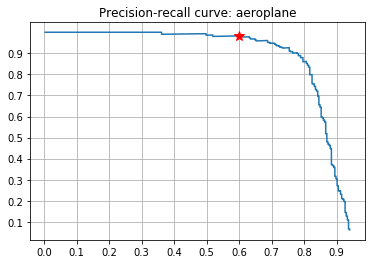


##############################
AP for bicycle = 0.8652
Corresponding precision: 0.9902, confidence score: 0.9305


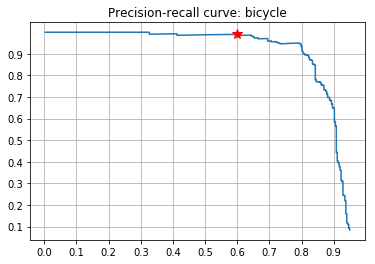


##############################
AP for bird = 0.7638
Corresponding precision: 0.9388, confidence score: 0.7639


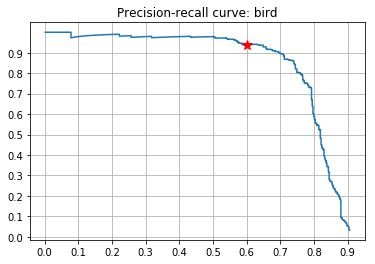


##############################
AP for boat = 0.7211
Corresponding precision: 0.8229, confidence score: 0.6139


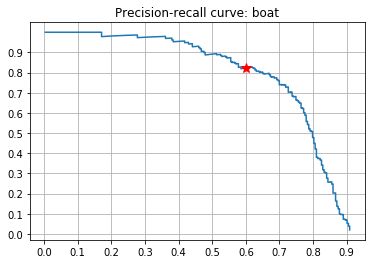


##############################
AP for bottle = 0.5082
Corresponding precision: 0.3801, confidence score: 0.1305


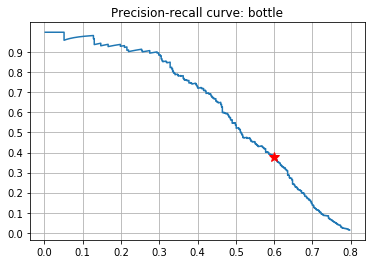


##############################
AP for bus = 0.8497
Corresponding precision: 0.9697, confidence score: 0.9744


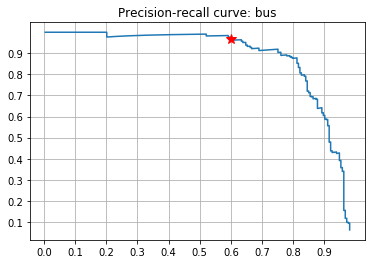


##############################
AP for car = 0.8615
Corresponding precision: 0.9810, confidence score: 0.9441


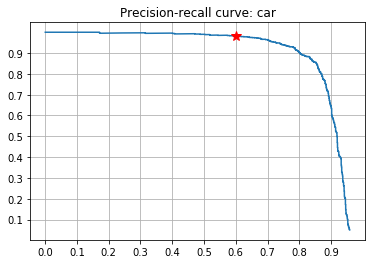


##############################
AP for cat = 0.8732
Corresponding precision: 0.9862, confidence score: 0.9872


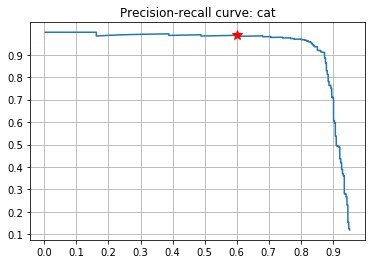


##############################
AP for chair = 0.6183
Corresponding precision: 0.6580, confidence score: 0.3757


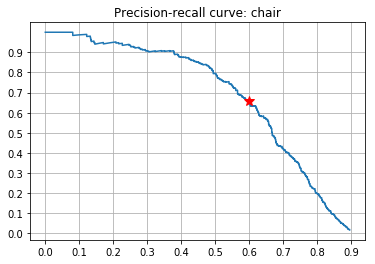


##############################
AP for cow = 0.8278
Corresponding precision: 0.9130, confidence score: 0.7261


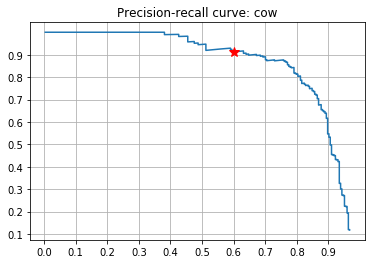


##############################
AP for diningtable = 0.7955
Corresponding precision: 0.8857, confidence score: 0.8214


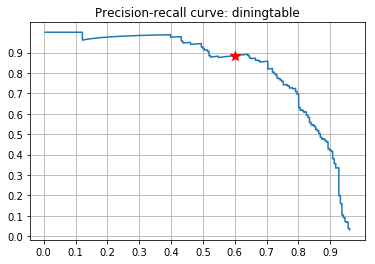


##############################
AP for dog = 0.8601
Corresponding precision: 0.9639, confidence score: 0.9718


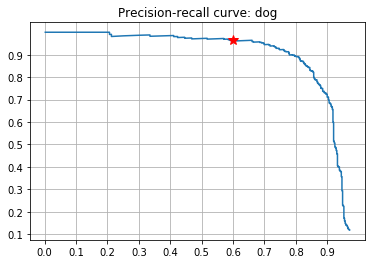


##############################
AP for horse = 0.8726
Corresponding precision: 0.9952, confidence score: 0.9808


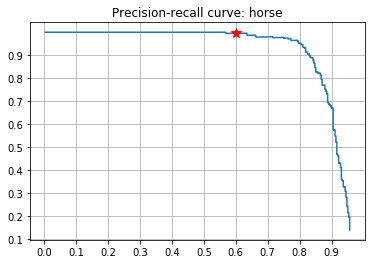


##############################
AP for motorbike = 0.8431
Corresponding precision: 0.9701, confidence score: 0.9387


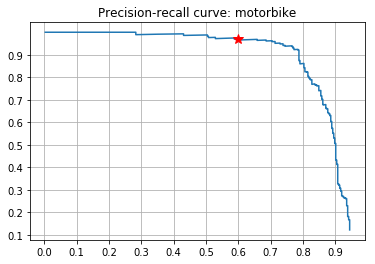


##############################
AP for person = 0.7893
Corresponding precision: 0.9418, confidence score: 0.7234


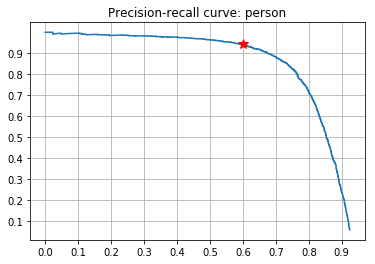


##############################
AP for pottedplant = 0.5019
Corresponding precision: 0.3740, confidence score: 0.1534


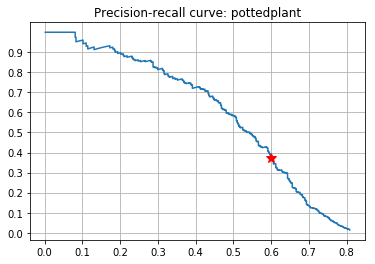


##############################
AP for sheep = 0.7726
Corresponding precision: 0.9542, confidence score: 0.7670


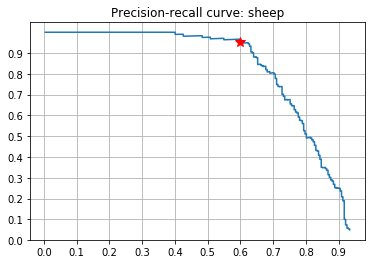


##############################
AP for sofa = 0.7893
Corresponding precision: 0.9000, confidence score: 0.8445


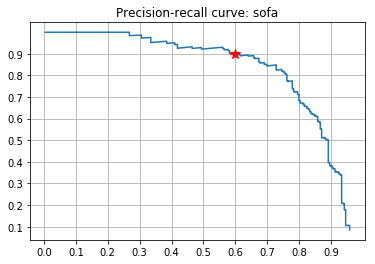


##############################
AP for train = 0.8694
Corresponding precision: 0.9770, confidence score: 0.9869


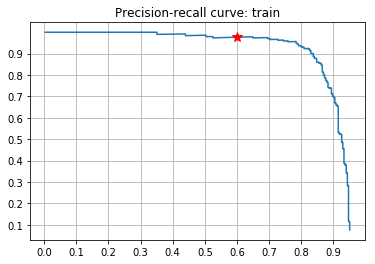


##############################
AP for tvmonitor = 0.7667
Corresponding precision: 0.9158, confidence score: 0.8713


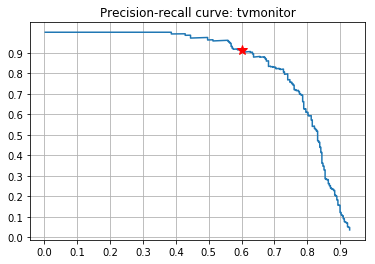


Mean AP = 0.7787


In [7]:
given_recall = 0.6

print('Evaluating detections')
print('Given recall: {}'.format(given_recall))
cachedir = os.path.join(save_folder, 'annotations_cache')
aps = []
for i, cls in enumerate(labelmap):
    
    print('#' * 30)

    ### [TODO] 
#     rec, prec, ap = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)
    rec, prec, ap, score = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)
    
    aps += [ap]
    print('AP for {} = {:.4f}'.format(cls, ap))
        
    ### [TODO]
#     corresponding_prec = None
#     corresponding_score = None
    idx = np.where(rec >= 0.6)[0][0]
    corresponding_prec = prec[idx]
    corresponding_score = score[idx]
    
    print('Corresponding precision: {:.4f}, confidence score: {:.4f}'.format(corresponding_prec, corresponding_score))
        
    # draw PR curve
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 1., 0.1))
    ax.plot(rec, prec)
    plt.grid()
    plt.title('Precision-recall curve: {:s}'.format(cls))
    plt.plot(given_recall, corresponding_prec, color='red', marker='*', markersize=10)
    plt.show()
    print('')
        
print('Mean AP = {:.4f}'.format(np.mean(aps)))

In [38]:
score

array([-0.99998736, -0.99994445, -0.99994195, ..., -0.01000388,
       -0.01000297, -0.01000285])

Evaluating detections
Given recall: 0.6
##############################
AP for aeroplane = 0.8203


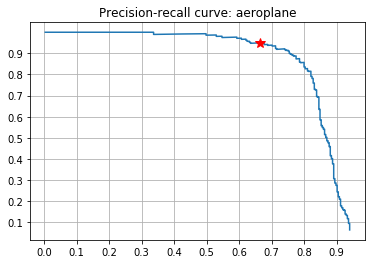


##############################
AP for bicycle = 0.8542


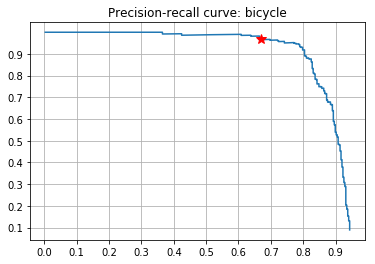


##############################
AP for bird = 0.7570


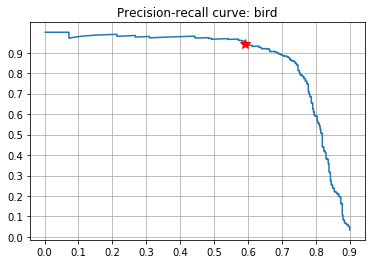


##############################
AP for boat = 0.7014


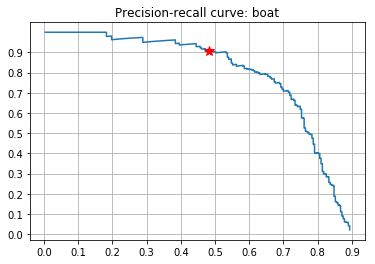


##############################
AP for bottle = 0.5018


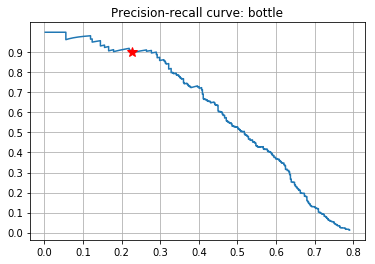


##############################
AP for bus = 0.8479


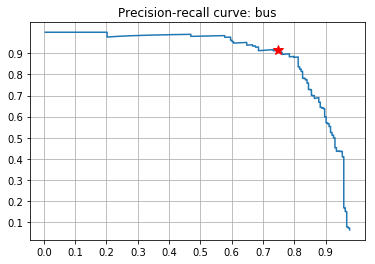


##############################
AP for car = 0.8589


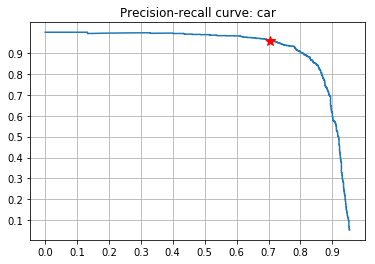


##############################
AP for cat = 0.8736


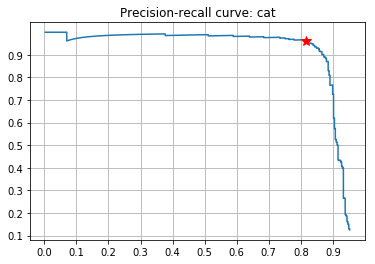


##############################
AP for chair = 0.6196


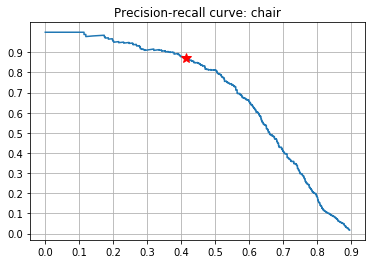


##############################
AP for cow = 0.8271


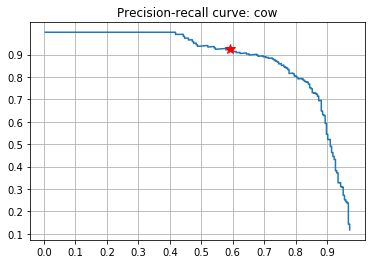


##############################
AP for diningtable = 0.7922


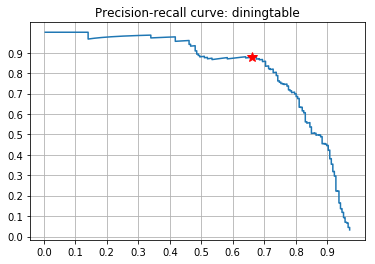


##############################
AP for dog = 0.8558


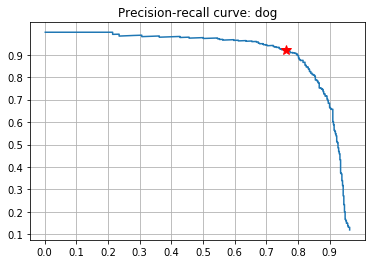


##############################
AP for horse = 0.8709


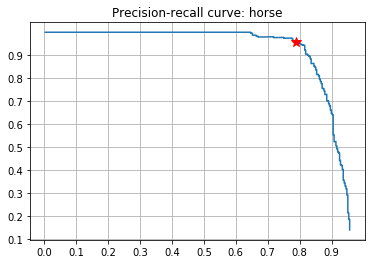


##############################
AP for motorbike = 0.8344


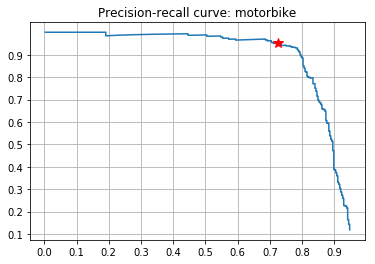


##############################
AP for person = 0.7912


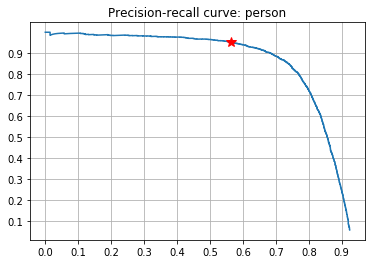


##############################
AP for pottedplant = 0.5047


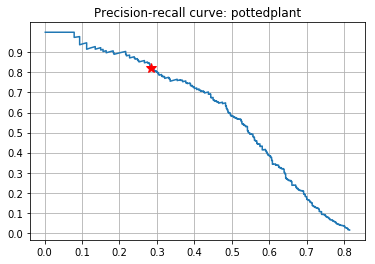


##############################
AP for sheep = 0.7771


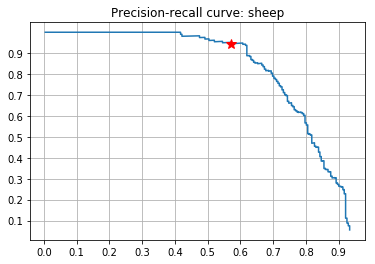


##############################
AP for sofa = 0.7913


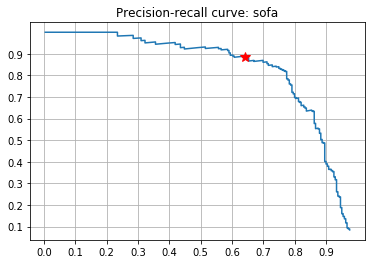


##############################
AP for train = 0.8623


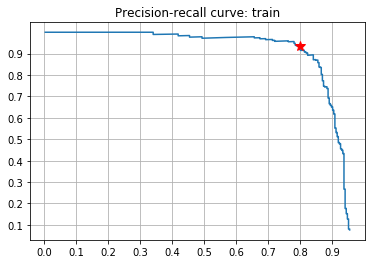


##############################
AP for tvmonitor = 0.7684


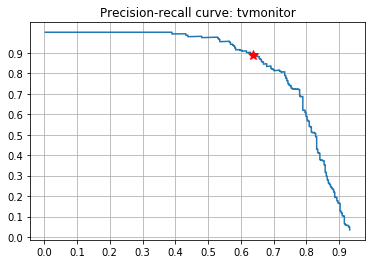


Mean AP = 0.7755


In [45]:
given_threshold = 0.8

print('Evaluating detections')
print('Given recall: {}'.format(given_recall))
cachedir = os.path.join(save_folder, 'annotations_cache')
aps = []
for i, cls in enumerate(labelmap):
    
    print('#' * 30)

    ### [TODO] 
#     rec, prec, ap = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)
    rec, prec, ap, score = voc_eval(all_boxes[i+1], annopath, imgsetpath.format(set_type), cls, cachedir, ovthresh=0.5)
    
    aps += [ap]
    print('AP for {} = {:.4f}'.format(cls, ap))
        
    ### [TODO]
#     corresponding_prec = None
#     corresponding_rec = None
    idx = np.where(score <= given_threshold)[0][0]
    corresponding_prec = prec[idx]
    corresponding_rec = rec[idx]
    
    # uncomment after writing code
    # print('Corresponding precision: {:.4f}, recall: {:.4f}'.format(corresponding_prec, corresponding_rec))
        
    # draw PR curve
    fig = plt.figure()
    ax = fig.gca()
    ax.set_xticks(np.arange(0, 1, 0.1))
    ax.set_yticks(np.arange(0, 1., 0.1))
    ax.plot(rec, prec)
    plt.grid()
    plt.title('Precision-recall curve: {:s}'.format(cls))                
    
    # uncomment after writing code
    plt.plot(corresponding_rec, corresponding_prec, color='red', marker='*', markersize=10)    
    
    plt.show()
    
    print('')
        
    
print('Mean AP = {:.4f}'.format(np.mean(aps)))